#**8-10. 텍스트 분석 실습 - 캐글 Mercari Price Suggestion Challenge**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


- Mercari Price Suggestion Challenge는 캐글에서 진행되는 챌린지로, 일본의 대형 온라인 쇼핑몰인 Mercari사의 제품에 대해 가격을 예측하는 과제
- 제공되는 데이터 세트는 제품에 대한 여러 속성 및 제품 설명 등의 텍스트 데이터로 구성
- 데이터를 기반으로 제품 예상 가격을 판매자들에게 제공
  - 이 프로세스를 구현하기 위해 판매자는 제품명, 브랜드명, 카테고리, 제품 설명 등 다양한 속성 정보 입력
  - ML 모델은 이 속성에 따라 제품의 예측 가격을 판매자에게 자동 제공

- 데이터 속성

  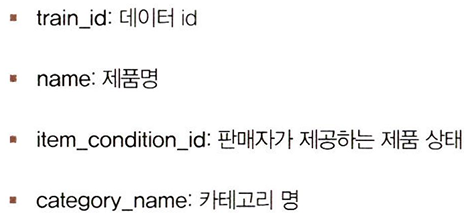
  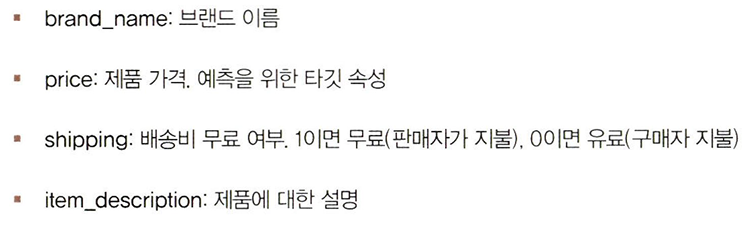

- price가 예측 해야 할 타깃 값
- 회귀로 피처를 학습한 뒤 price를 예측
- 기존 회귀 예제와 다른 점: item_description과 같은 텍스트 형태의 비정형 데이터와 다른 정형 속성을 같이 적용해 회귀를 수행

##**1) 데이터 전처리**

In [2]:
from sklearn.linear_model import Ridge , LogisticRegression
from sklearn.model_selection import train_test_split , cross_val_score
from sklearn.feature_extraction.text import CountVectorizer , TfidfVectorizer
import pandas as pd

mercari_df= pd.read_csv('/content/drive/MyDrive/Euron7_ML/data/mercari_train.tsv',sep='\t')
print(mercari_df.shape)
mercari_df.head(3)

(1482535, 8)


,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...


In [3]:
print(mercari_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1482535 entries, 0 to 1482534
Data columns (total 8 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   train_id           1482535 non-null  int64  
 1   name               1482535 non-null  object 
 2   item_condition_id  1482535 non-null  int64  
 3   category_name      1476208 non-null  object 
 4   brand_name         849853 non-null   object 
 5   price              1482535 non-null  float64
 6   shipping           1482535 non-null  int64  
 7   item_description   1482529 non-null  object 
dtypes: float64(1), int64(3), object(4)
memory usage: 90.5+ MB
None


- brand_name은 가격에 영향을 미치는 중요 요인이라고 판단 but, null데이터가 많음
- category_name의 null데이터도 많은 편
- item_description의 null값은 4건으로 미비


- Target값이 price 칼럼의 데이터 분포도 살피기
  - 회귀에서 Target값의 정규 분포도는 매우 중요
  - 왜곡돼 있을 경우 보통 로그를 씌워서 변환하면 대부분 정규 분포의 형태를 가짐

<Figure size 600x400 with 0 Axes>

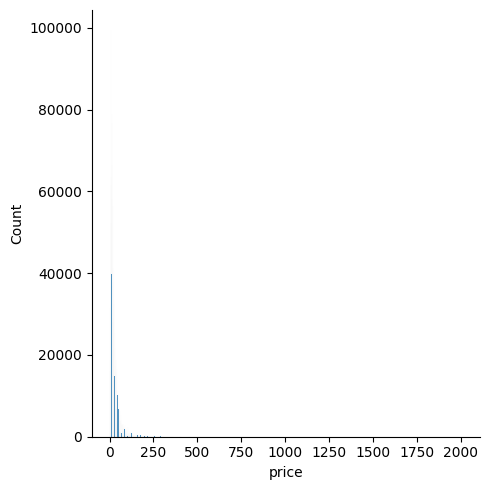

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

y_train_df = mercari_df['price']
plt.figure(figsize=(6,4))
sns.displot(y_train_df, kde=False)

- price 값이 비교적 적은 가격을 가진 데이터 값에 왜곡돼 분포

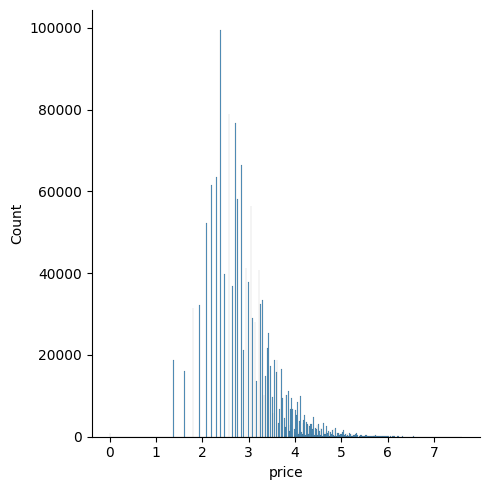

In [6]:
import numpy as np

y_train_df = np.log1p(y_train_df)
sns.displot(y_train_df, kde=False)

- 로그 값으로 변환하면 price값이 비교적 정규 분포에 가까워짐

In [7]:
# price 칼럼을 원래 값에서 로그로 변환된 값으로 변경
mercari_df['price'] = np.log1p(mercari_df['price'])
mercari_df['price'].head(3)

,price
0,2.397895
1,3.970292
2,2.397895


In [8]:
print('Shipping 값 유형:\n', mercari_df['shipping'].value_counts())
print('\nitem_condition_id 값 유형:\n',mercari_df['item_condition_id'].value_counts())

Shipping 값 유형:
 shipping
0    819435
1    663100
Name: count, dtype: int64

item_condition_id 값 유형:
 item_condition_id
1    640549
3    432161
2    375479
4     31962
5      2384
Name: count, dtype: int64


- shipping 칼럼은 배송비 유무를 의미, 값이 비교적 균일
- item_condition_id는 판매자가 제공하는 제품 상태, 의미하는 바는 캐글에 기재돼있지 않아 알 수 없음, 1 2 3이 주를 이룸

In [9]:
boolean_cond = mercari_df['item_description'] == 'No description yet'
mercari_df[boolean_cond]['item_description'].count()

82489

- No description yet의 경우도 null과 마찬가지로 의미 있는 속성값X -> 적절한 값으로 변경 필요

- category_name : '/'를 기준으로 단어를 토큰화해 각각의 피처로 저장하고 이를 이용해 알고리즘 학습
  - '/'기준으로 대 중 소 분류를 효과적으로 분리해내기 위해 별도의 split_cat()함수 생성
  - null값이 있어서 이에 유의 해야함
    - null값인 경우 함수가 error발생 -> except catch를 하여 대,중,소 분류 모두 'Other Null'값 부여
  - 판다스의 apply lambda로 반환되는 데이터 셋이 리스트를 요소로 가짐. 근데 이를 다시 DataFrame칼럼으로 분리 필요 -> zip과 *를 apply lambda식에 적용

In [10]:
# apply lambda에서 호출되는 대,중,소 분할 함수 생성, 대,중,소 값을 리스트로 반환
def split_cat(category_name):
  try:
    return category_name.split('/')
  except:
    return ['Other_Null','Other_Null','Other_Null']

# 위의 split_cat()을 apply lambda에서 호출해 대,중,소 칼럼을 mercari_df에 생성
mercari_df['cat_dae'], mercari_df['cat_jung'], mercari_df['cat_so'] = \
zip(*mercari_df['category_name'].apply(lambda x : split_cat(x)))

# 대분류만 값의 유형과 건수를 살펴보고, 중분류, 소분류는 값의 유형이 많으므로 분류 개수만 추출
print('대분류 유형:\n',mercari_df['cat_dae'].value_counts())
print('중분류 개수:',mercari_df['cat_jung'].nunique())
print('소분류 개수:',mercari_df['cat_so'].nunique())

대분류 유형:
 cat_dae
Women                     664385
Beauty                    207828
Kids                      171689
Electronics               122690
Men                        93680
Home                       67871
Vintage & Collectibles     46530
Other                      45351
Handmade                   30842
Sports & Outdoors          25342
Other_Null                  6327
Name: count, dtype: int64
중분류 개수: 114
소분류 개수: 871


- brand_name의 null -> 일괄적으로 'Other_Null'로 변경

In [11]:
mercari_df['brand_name'] = mercari_df['brand_name'].fillna(value='Other_Null')
mercari_df['category_name'] = mercari_df['category_name'].fillna(value='Other_Null')
mercari_df['item_description'] = mercari_df['item_description'].fillna(value='Other_Null')

# 각 칼럼별로 Null 값 건수 확인. 모두 0이 나와야 합니다.
mercari_df.isnull().sum()

,0
train_id,0
name,0
item_condition_id,0
category_name,0
brand_name,0
price,0
shipping,0
item_description,0
cat_dae,0
cat_jung,0


- 데이터 클렌징 작업 완료(모두 null값이 0)
- 다음 작업 : 칼럼을 숫자형 코드 값으로 인코딩, 텍스트형 칼럼은 피처 벡터화 변환 적용

##**2) 피처 인코딩과 피처 벡터화**

- 예측 모델은 price값, 즉 상품 가격을 예측 해야함 -> 회귀 모델 기반
- 선형 회귀 모델과 회귀 트리 모델 모두 적용할 예정
- 선형 회귀의 경우 원-핫 인코딩 적용이 훨씬 선호됨 -> 인코딩할 피처는 모두 원-핫 인코딩을 적용
- 피처 벡터화
  - 비교적 짧은 텍스트의 경우 : Count 기반의 벡터화
  - 긴 텍스트 : TD-IDF 기반의 벡터화

In [12]:
print('brand name의 유형 건수:',mercari_df['brand_name'].nunique())
print('brand name sample 5건:\n',mercari_df['brand_name'].value_counts()[:5])

brand name의 유형 건수: 4810
brand name sample 5건:
 brand_name
Other_Null           632682
PINK                  54088
Nike                  54043
Victoria's Secret     48036
LuLaRoe               31024
Name: count, dtype: int64


- brand_name: 원-핫 인코딩으로 변환

In [13]:
print('name의 종류 개수:',mercari_df['name'].nunique())
print('name sample 10건:\n',mercari_df['name'][:10])

name의 종류 개수: 1225273
name sample 10건:
 0       MLB Cincinnati Reds T Shirt Size XL
1          Razer BlackWidow Chroma Keyboard
2                            AVA-VIV Blouse
3                     Leather Horse Statues
4                      24K GOLD plated rose
5          Bundled items requested for Ruie
6        Acacia pacific tides santorini top
7      Girls cheer and tumbling bundle of 7
8                     Girls Nike Pro shorts
9    Porcelain clown doll checker pants VTG
Name: name, dtype: object


- name : 유형이 매우 많고, 적은 단어 위주의 텍스트 형태 -> Count기반 피처 벡터화 변환

- category_name : 대 중 소 칼럼을 원-핫 인코딩
- shipping : 두 가지 유형의 값 -> 원-핫 인코딩
- item_condition_id : 다섯 가지 유형의 값 -> 원-핫 인코딩

In [14]:
pd.set_option('max_colwidth',200)

# item_description의 평균 문자열 크기
print('item_description 평균 문자열 크기:',mercari_df['item_description'].str.len().mean())

mercari_df['item_description'][:2]

item_description 평균 문자열 크기: 145.71139703278507


,item_description
0,No description yet
1,This keyboard is in great condition and works like it came out of the box. All of the ports are tested and work perfectly. The lights are customizable via the Razer Synapse app on your PC.


- item_description: 평균 문자열이 비교적 큼 -> TF-IDF 변환

In [15]:
# name 속성에 대한 피처 벡터화 변환
cnt_vec = CountVectorizer()
X_name = cnt_vec.fit_transform(mercari_df.name)

# item_description에 대한 피처 벡터화 변환
tfidf_vec = TfidfVectorizer(max_features=50000,ngram_range=(1,3),stop_words='english')
X_descp = tfidf_vec.fit_transform(mercari_df['item_description'])

print('name vectorization shape:',X_name.shape)
print('item_description vectorization shape:',X_descp.shape)

name vectorization shape: (1482535, 105757)
item_description vectorization shape: (1482535, 50000)


- CountVectorizier, TfidfVectorizer가 fit_transform()을 통해 반환되는 데이터는 희소 행렬
- 희소 행렬 객체 변수인 X_name, X_descp를 새로 결합해 새로운 데이터 셋으로 구성 필요
- 앞으로 인코딩 될 칼럼들도 모두 X_name, X_descp와 결합돼 ML모델을 실행하는 기반 데이터 셋으로 재구성 필요


- 인코딩 대상 칼럼도 밀집 행렬 형태가 아닌 희소 행렬 형태로 인코딩 적용 후 함께 결합
- 모든 인코딩 대상 칼럼은 LabelBinarizer를 이용해 희소 행렬 형태의 원-핫 인코딩으로 변환
  - 생성 시 sparse_out=True로 파라미터 설정
  - sparse모듈의 hstack()함수를 이용하여 희소 행렬 결합
    - hstack(): 희소 행렬을 쉽게 칼럼 레벨로 결합할 수 있게 해줌

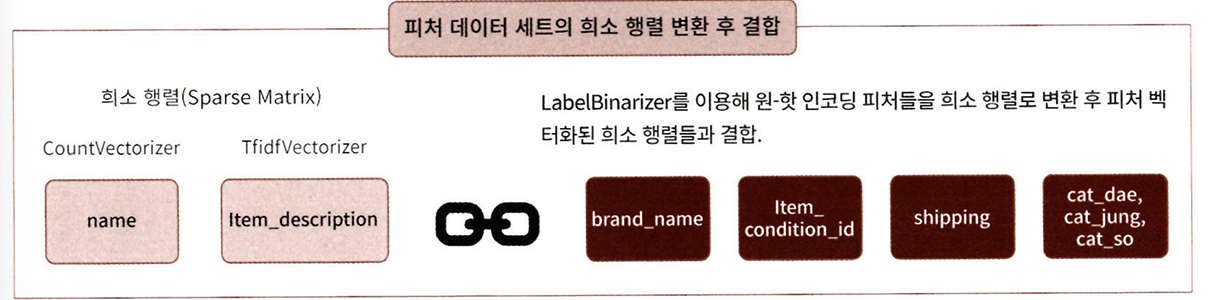

In [16]:
from sklearn.preprocessing import LabelBinarizer

# brand_name, item_condition_id, shipping 각 피처들을 희소 행렬 원-핫 인코딩 변환
lb_brand_name = LabelBinarizer(sparse_output=True)
X_brand = lb_brand_name.fit_transform(mercari_df['brand_name'])
lb_item_cond_id = LabelBinarizer(sparse_output=True)
X_item_cond_id = lb_item_cond_id.fit_transform(mercari_df['item_condition_id'])
lb_shipping = LabelBinarizer(sparse_output=True)
X_shipping = lb_shipping.fit_transform(mercari_df['shipping'])

# cat_dae, cat_jung, cat_so 각 피처들을 희소 행렬 원-핫 인코딩 변환
lb_cat_dae = LabelBinarizer(sparse_output=True)
X_cat_dae = lb_cat_dae.fit_transform(mercari_df['cat_dae'])
lb_cat_jung = LabelBinarizer(sparse_output=True)
X_cat_jung = lb_cat_jung.fit_transform(mercari_df['cat_jung'])
lb_cat_so = LabelBinarizer(sparse_output=True)
X_cat_so = lb_cat_so.fit_transform(mercari_df['cat_so'])

In [17]:
print(type(X_brand), type(X_item_cond_id), type(X_shipping))
print('X_brand shape:{0}, X_item_cond_id shape:{1}'.format(X_brand.shape, X_item_cond_id.shape))
print('X_shipping shape:{0}, X_cat_dae shape:{1}'.format(X_shipping.shape, X_cat_dae.shape))
print('X_cat_jung shape:{0}, X_cat_so shape:{1}'.format(X_cat_jung.shape, X_cat_so.shape))

<class 'scipy.sparse._csr.csr_matrix'> <class 'scipy.sparse._csr.csr_matrix'> <class 'scipy.sparse._csr.csr_matrix'>
X_brand shape:(1482535, 4810), X_item_cond_id shape:(1482535, 5)
X_shipping shape:(1482535, 1), X_cat_dae shape:(1482535, 11)
X_cat_jung shape:(1482535, 114), X_cat_so shape:(1482535, 871)


- 인코딩 변환된 데이터 셋이 CSR형태로 변환된 csr_matrix타입

- 앞에서 피처 벡터화 변환한 데이터 셋와 희소 인코딩 변환된 데이터 셋을 hstack()을 이용해 모두 결합
- 결합된 데이터는 Mercari Price Suggestion을 위한 기반 데이터 셋으로 사용, 여기서는 데이터 타입과 크기만 확인한 후 메모리에서 삭제
  - 결합된 데이터가 큰 메모리 -> 메모리 오류 발생 가능성 -> del '객체 변수명'과 gc.collect()로 결합 데이터를 메모리에서 삭제

In [18]:
from scipy.sparse import hstack
import gc

sparse_matrix_list = (X_name, X_descp, X_brand, X_item_cond_id,\
                      X_shipping, X_cat_dae, X_cat_jung, X_cat_so)

# hstack 함수를 이용해 인코딩과 벡터화를 수행한 데이터 세트를 모두 결합
X_features_sparse = hstack(sparse_matrix_list).tocsr()
print(type(X_features_sparse), X_features_sparse.shape)

# 데이터 세트가 메모리를 많이 차지하므로 사용 목적이 끝났으면 바로 메모리에서 삭제
del X_features_sparse
gc.collect()

<class 'scipy.sparse._csr.csr_matrix'> (1482535, 161569)


0

##**3) 릿지 회귀 모델 구축 및 평가**

- 여러 알고리즘 모델과 희소 행렬을 변환하고 예측 성능을 비교하면서 테스트를 수행할 것임 -> 필요한 로직 함수화
  - 모델 평가 로직 함수화
    - RMSLE방식: RMSE와 유사, 오류값에 로그를 취해 RMSE를 구하는 방식, 낮은 가격보다 높은 가격에서 오류가 발생할 경우 오류 값이 더 커지는 것을 억제 하기 위해 이 방식 도입
    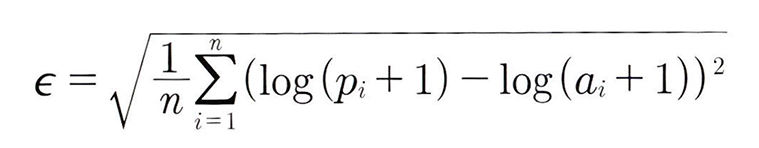

- 주의 할 점 : price칼럼이 왜곡된 분포를 갖고 있어, 이전에 로그 값으로 변환시킴 -> 이에 따라 학습할 모델이 사용할 price값은 로그 값으로 변환됨 price값이므로 예측도 로그로 변환된 데이터 값 수준의 price값을 예측

  => 따라서 학습 모델을 이용한 price값은 다시 로그의 역변환인 지수 변환을 수행해 원복해야함


In [19]:
def rmsle(y, y_pred):
  # underflow, overflow를 막기 위해 log가 아닌 log1p로 rmsle계산
  return np.sqrt(np.mean(np.power(np.log1p(y)-np.log1p(y_pred),2)))

def evaluate_org_price(y_test, preds):
  # 원본 데이터는 log1p로 변환되었으므로 exmpm1로 원복 필요
  preds_exmpm = np.expm1(preds)
  y_test_exmpm = np.expm1(y_test)

  # rmsle로 RMSLE 값 추출
  rmsle_result = rmsle(y_test_exmpm, preds_exmpm)
  return rmsle_result

- 학습용 데이터를 생성하고 모델을 학습/예측하는 로직을 별도의 함수로 생성

In [20]:
import gc
from scipy.sparse import hstack

def model_train_predict(model,matrix_list):
  # scipy.sparse 모듈의 hstack을 이용해 희소 행렬 결합
  X = hstack(matrix_list).tocsr()

  X_train, X_test, y_train, y_test = train_test_split(X, mercari_df['price'],
                                                      test_size=0.2, random_state=156)

  # 모델 학습 및 예측
  model.fit(X_train, y_train)
  preds = model.predict(X_test)

  del X, X_train, X_test, y_train
  gc.collect()

  return preds, y_test

- 회귀 예측 수행 전 상품 예측에 item_description과 같은 텍스트 형태의 속성이 얼마나 영향을 미치는지 알아보자

In [21]:
linear_model = Ridge(solver="lsqr",fit_intercept=False)

sparse_matrix_list = (X_name, X_brand, X_item_cond_id,
                      X_shipping, X_cat_dae, X_cat_jung, X_cat_so)
linear_preds, y_test = model_train_predict(model=linear_model, matrix_list=sparse_matrix_list)
print('Item Description을 제외했을 때 rmsle 값:',evaluate_org_price(y_test,linear_preds))

sparse_matrix_list = (X_descp, X_name, X_brand, X_item_cond_id, \
                      X_shipping, X_cat_dae, X_cat_jung, X_cat_so)
linear_preds, y_test = model_train_predict(model=linear_model, matrix_list=sparse_matrix_list)
print('Item Description을 포함한 rmsle값:', evaluate_org_price(y_test, linear_preds))

Item Description을 제외했을 때 rmsle 값: 0.4983990938999374
Item Description을 포함한 rmsle값: 0.4680348033168731


- Item Description을 포함했을 때 rmsle값이 많이 감소 -> 영향이 중요

##**4) LightGBM 회귀 모델 구축과 앙상블을 이용한 최종 예측 평가**

- LightGBM을 이용해 회귀를 수행한 뒤, 위에서 구한 릿지 모델 예측값과 LightGBM모델 예측값을 간단한 앙상블 방식으로 섞어서 최종 회귀 예측값 평가

여기 밑에 두 개 코드 중 앞 코드가 두 시간 넘게 걸려서 n_estimators=50으로 줄이고 실행 해보고 그랬는데도 너무 오래 걸려서 결국 두 개 다 실행결과는 출력하지 못 했습니다 죄송하니다 ㅠ

In [ ]:
from lightgbm import LGBMRegressor

sparse_matrix_list = (X_descp, X_name, X_brand, X_item_cond_id,
                      X_shipping, X_cat_dae, X_cat_jung, X_cat_so)

lgbm_model = LGBMRegressor(n_estimators=200, learning_rate=0.5, num_leaves=125, random_state=156)
lgbm_preds, y_test = model_train_predict(model=lgbm_model, matrix_list=sparse_matrix_list)
print('LightGBM rmsle 값:',evaluate_org_price(y_test, lgbm_preds))

In [ ]:
preds = lgbm_preds * 0.45 + linear_preds * 0.55
print('LightGBM과 Ridge를 ensemble한 최종 rmsle값:',evaluate_org_price(y_test,preds))